<a href="https://colab.research.google.com/github/arina19-2000/unimi/blob/main/tesi/kids_survey.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/colab

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/colab


In [33]:
pip install ydata-profiling

In [34]:
pip install catboost

In [35]:
pip install mord

In [36]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from ydata_profiling import ProfileReport
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.stats.api as sms
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from patsy import dmatrices
from statsmodels.miscmodels.ordinal_model import OrderedModel
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from mord import LogisticIT, LAD
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from catboost import CatBoostClassifier
import shap

In [37]:
df_kids = pd.read_excel('dfc_test.xlsx')

In [38]:
df_kids

,Unnamed: 0,genere,adozione_int,adopt_age,prima_classe_frequenza_scuola,g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992,g2q00013_presenza_certificazione_sensi_l170_2010,g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni,g2q00036_fatto_esperienze_allestero,prospettive_economiche_rispetto_genitori_sonosaranno_encoded,...,esperienza_ss,esperienza_sp,g2q00022sq001_sq002_valutazione_voto100,g8q00002_qual_titolo_studio_massimo_conseguito_padre,g7q00002_qual_titolo_studio_massimo_conseguito_madre,g2q00015_qual_titolo_studio_massimo_conseguito,g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti,g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre,g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre,g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici
0,1,1,0,0,1,0,0,27,No,99,...,0,0,0,1.0,0.5,6,1,1,1,1
1,2,0,1,4,1,0,0,99,"Sì, di lavoro",99,...,0,1,70,7.0,7.0,3,3,1,1,1
2,6,0,1,1,1,0,1,99,No,99,...,1,0,85,3.0,6.0,3,1,4,4,1
3,9,0,1,11,99,1,0,26,No,99,...,0,0,0,3.0,6.0,6,2,4,3,4
4,14,1,0,9,6,0,0,24,"Sì, di studio (non estivo)",99,...,0,1,0,99.0,6.0,6,4,4,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100,221,1,0,2,4,0,0,19,"Sì, di studio (non estivo)",99,...,0,2,0,3.0,5.0,3,3,4,2,1
101,224,1,0,1,3,0,0,26,"Sì, di lavoro",99,...,1,0,76,3.0,2.0,3,3,3,3,2
102,227,1,0,0,1,0,99,99,"Sì, di lavoro e di studio (non estivo)",99,...,1,2,0,5.0,6.0,4,99,99,2,1
103,233,0,0,0,3,99,99,24,No,99,...,0,0,0,2.0,3.0,3,3,3,2,2


In [39]:
# Define the mapping for encoding
experience_mapping = {
    "Sì, di studio (non estivo)": 1,
    "Sì, di lavoro e di studio (non estivo)": 1,
    "Sì, di lavoro": 1,
    "No": 0,
    "99": 0
}

df_kids['g2q00036_fatto_esperienze_allestero'] = df_kids['g2q00036_fatto_esperienze_allestero'].map(experience_mapping)
print(df_kids['g2q00036_fatto_esperienze_allestero'].value_counts())

g2q00036_fatto_esperienze_allestero
0.0    68
1.0    30
Name: count, dtype: int64


In [40]:
df_kids = df_kids.apply(lambda col: col.replace(99, col.mode()[0]) if 99 in col.values else col)


In [41]:
df_kids['g2q00015_qual_titolo_studio_massimo_conseguito'] = df_kids['g2q00015_qual_titolo_studio_massimo_conseguito'].replace({7: 6, 8: 6,1:2, 4:5})

In [42]:
df_kids['g2q00015_qual_titolo_studio_massimo_conseguito'].value_counts()

,count
g2q00015_qual_titolo_studio_massimo_conseguito,
3,43
5,27
2,19
6,16


In [43]:
df_kids = df_kids.dropna(subset=['g2q00015_qual_titolo_studio_massimo_conseguito'])

In [44]:
mean_adopt_age = df_kids.loc[df_kids['adopt_age'] <= 18, 'adopt_age'].mean()
df_kids.loc[df_kids['adopt_age'] > 18, 'adopt_age'] = mean_adopt_age
print(df_kids['adopt_age'].value_counts())

adopt_age
1.0     22
0.0     17
2.0     12
4.0      9
7.0      9
3.0      8
6.0      7
8.0      7
11.0     3
12.0     3
10.0     3
9.0      2
5.0      2
13.0     1
Name: count, dtype: int64


<ipython-input-44-af56b570ef76>:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '3.876190476190476' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_kids.loc[df_kids['adopt_age'] > 18, 'adopt_age'] = mean_adopt_age


In [45]:
df_kids = df_kids.drop(columns=['Unnamed: 0','prospettive_economiche_rispetto_genitori_sonosaranno_encoded','esperienza_uni'])

In [46]:
for col in df_kids.columns:
    print(col)

genere
adozione_int
adopt_age
prima_classe_frequenza_scuola
g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992
g2q00013_presenza_certificazione_sensi_l170_2010
g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni
g2q00036_fatto_esperienze_allestero
esperienza_ss
esperienza_sp
g2q00022sq001_sq002_valutazione_voto100
g8q00002_qual_titolo_studio_massimo_conseguito_padre
g7q00002_qual_titolo_studio_massimo_conseguito_madre
g2q00015_qual_titolo_studio_massimo_conseguito
g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti
g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre
g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre
g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici


In [47]:
target_variable = "g2q00015_qual_titolo_studio_massimo_conseguito"
numeric_vars = ["adopt_age", "g2q00022sq001_sq002_valutazione_voto100", "g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni"]

categorical_vars = [col for col in df_kids.columns if col not in numeric_vars + [target_variable]]
df_cleaned = df_kids.dropna(axis=1, thresh=len(df_kids) * 0.7).copy()

for col in numeric_vars:
    if col in df_cleaned.columns:
        df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].median())

if numeric_vars:
    scaler = StandardScaler()
    df_cleaned[numeric_vars] = scaler.fit_transform(df_cleaned[numeric_vars])

for col in categorical_vars:
    if col in df_cleaned.columns:
        if df_cleaned[col].dropna().shape[0] > 0:
            df_cleaned[col] = df_cleaned[col].fillna(df_cleaned[col].dropna().mode()[0])

print("Missing values:\n", df_cleaned.isnull().sum().sum())

Missing values:
 0


In [48]:
target_column = "g2q00015_qual_titolo_studio_massimo_conseguito"

numeric_cols = df_cleaned.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col != target_column]

z_scores = df_cleaned[numeric_cols].apply(zscore, nan_policy='omit')
outlier_rows = df_cleaned[(z_scores > 3).any(axis=1) | (z_scores < -3).any(axis=1)]
filtered_outlier_rows = outlier_rows[outlier_rows[target_column] != 3].copy()

for col in numeric_cols:
    upper_bound = df_cleaned[col].mean() + 3 * df_cleaned[col].std()
    lower_bound = df_cleaned[col].mean() - 3 * df_cleaned[col].std()

    filtered_outlier_rows.loc[:, col] = filtered_outlier_rows[col].clip(lower=lower_bound, upper=upper_bound).astype(df_cleaned[col].dtype)

df_cleaned.update(filtered_outlier_rows)


In [49]:
outliers = (z_scores > 3) | (z_scores < -3)
outlier_counts = outliers.sum()

# Summarize outliers
outlier_summary = pd.DataFrame({
    "Column": numeric_cols,
    "Outlier Count": outlier_counts
}).sort_values(by="Outlier Count", ascending=False)
print(outlier_summary)

                                                                                               Column  \
g2q00013_presenza_certificazione_sensi_l170_2010     g2q00013_presenza_certificazione_sensi_l170_2010   
g2q00012_presenza_patologie_certificate_sensi_1...  g2q00012_presenza_patologie_certificate_sensi_...   
esperienza_ss                                                                           esperienza_ss   
prima_classe_frequenza_scuola                                           prima_classe_frequenza_scuola   
g2q00022sq001_sq002_valutazione_voto100                       g2q00022sq001_sq002_valutazione_voto100   
g2q00030asq003_pesato_seguenti_figure_scelta_sc...  g2q00030asq003_pesato_seguenti_figure_scelta_s...   
g2q00030asq002_pesato_seguenti_figure_scelta_sc...  g2q00030asq002_pesato_seguenti_figure_scelta_s...   
g2q00030asq001_pesato_seguenti_figure_scelta_sc...  g2q00030asq001_pesato_seguenti_figure_scelta_s...   
g7q00002_qual_titolo_studio_massimo_conseguito_...  g7q

In [50]:
profile = ProfileReport(df_kids, title="Profiling Report")

In [51]:
def gauss_markov_assumptions(X, y):

    # 1. Independence of Errors: Durbin-Watson test
    X_with_intercept = sm.add_constant(X)
    ols_model = sm.OLS(y, X_with_intercept).fit()
    dw_statistic = sm.stats.durbin_watson(ols_model.resid)
    print(f"Durbin-Watson statistic: {dw_statistic}")


    # 2. Breusch-Pagan Test for homoscedasticity
    bp_test = sms.het_breuschpagan(ols_model.resid, ols_model.model.exog)
    print(f"Breusch-Pagan Test p-value: {bp_test[1]}")

    # 3. VIF
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    print("\nVariance Inflation Factors (VIF):")
    print(vif_data)

X = df_cleaned.drop(columns=['g2q00015_qual_titolo_studio_massimo_conseguito'])
y = df_cleaned['g2q00015_qual_titolo_studio_massimo_conseguito']

In [52]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for train_idx, test_idx in skf.split(X, y):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

print("Class distribution in y_train:")
print(y_train.value_counts())

print("\nClass distribution in y_test:")
print(y_test.value_counts())

Class distribution in y_train:
g2q00015_qual_titolo_studio_massimo_conseguito
3    35
5    21
2    15
6    13
Name: count, dtype: int64

Class distribution in y_test:
g2q00015_qual_titolo_studio_massimo_conseguito
3    8
5    6
2    4
6    3
Name: count, dtype: int64


In [53]:
gauss_markov_assumptions(X_train, y_train)

Durbin-Watson statistic: 2.22442933459397
Breusch-Pagan Test p-value: 0.037685624459196744

Variance Inflation Factors (VIF):
                                              feature        VIF
0                                              genere   3.451937
1                                        adozione_int   2.454259
2                                           adopt_age   1.594992
3                       prima_classe_frequenza_scuola   7.328209
4   g2q00012_presenza_patologie_certificate_sensi_...   1.646220
5    g2q00013_presenza_certificazione_sensi_l170_2010   1.459424
6   g2q00035sq001_sq001_età_conquistato_indipenden...   1.431620
7                 g2q00036_fatto_esperienze_allestero   2.148693
8                                       esperienza_ss   2.277185
9                                       esperienza_sp   2.480061
10            g2q00022sq001_sq002_valutazione_voto100   2.102385
11  g8q00002_qual_titolo_studio_massimo_conseguito...   8.545870
12  g7q00002_qual_titolo_stud

In [54]:
high_vif_columns = ['g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre','g8q00002_qual_titolo_studio_massimo_conseguito_padre']
df_cleaned = df_cleaned.drop(columns=high_vif_columns)

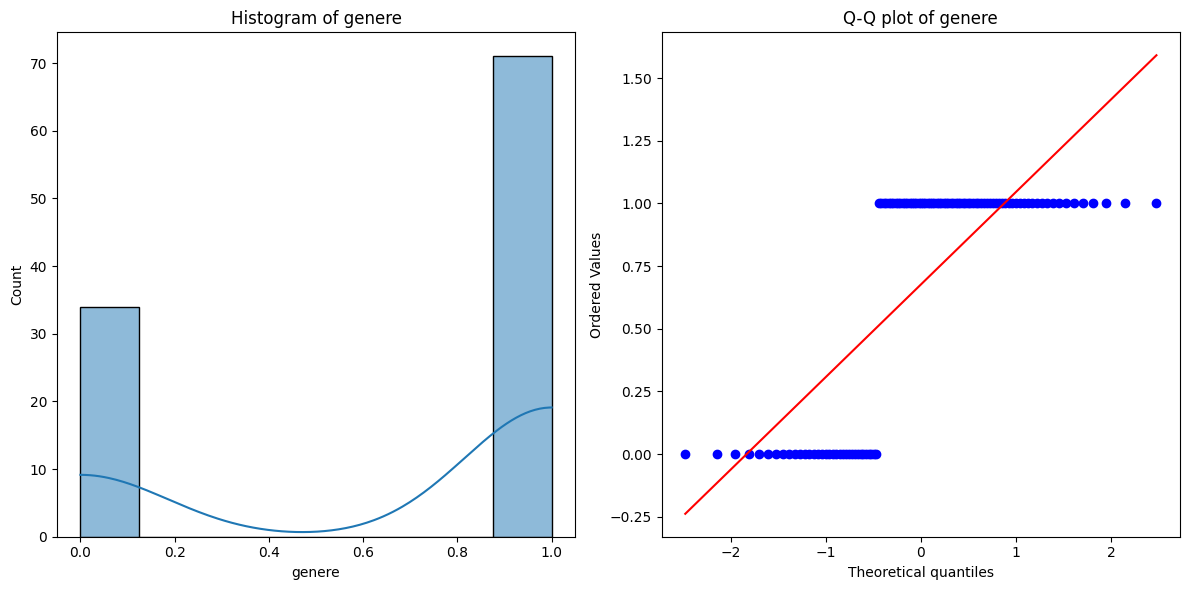

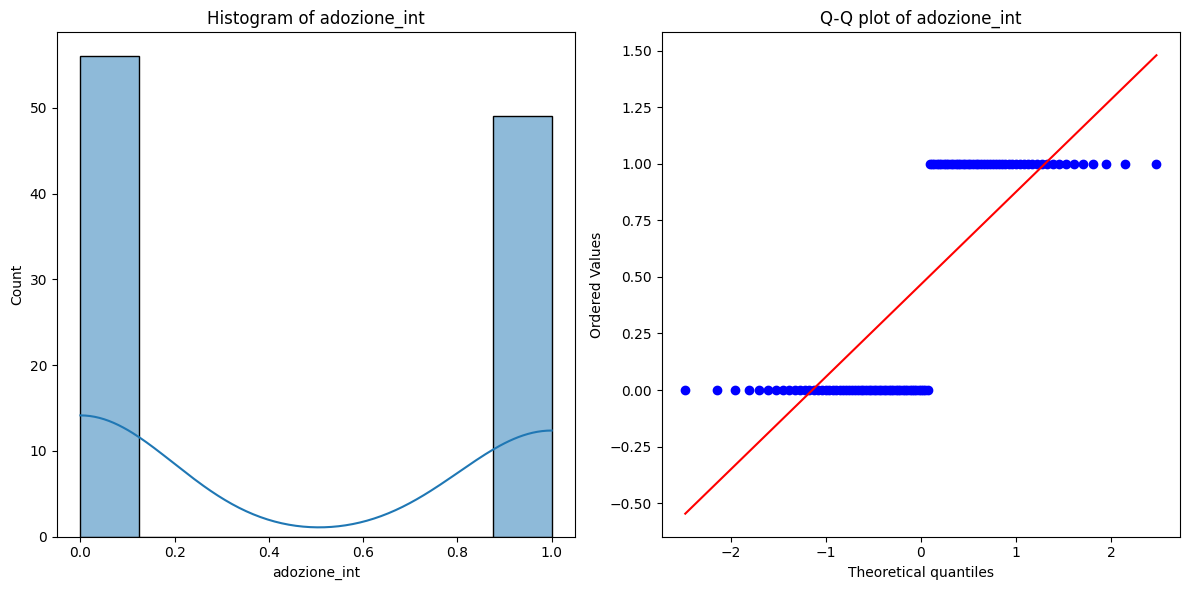

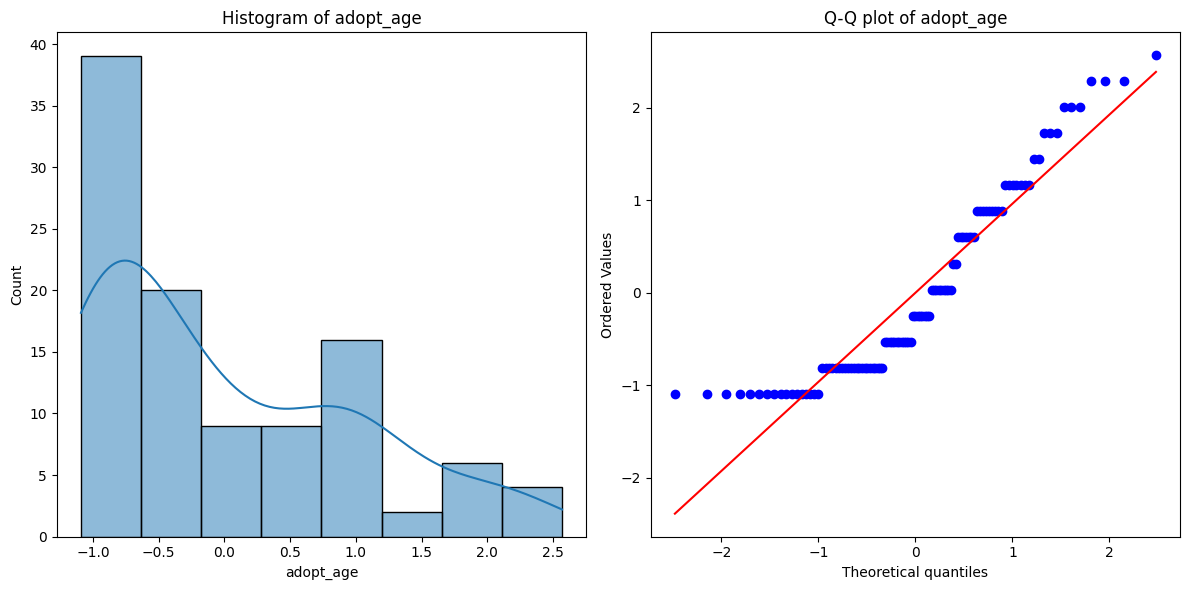

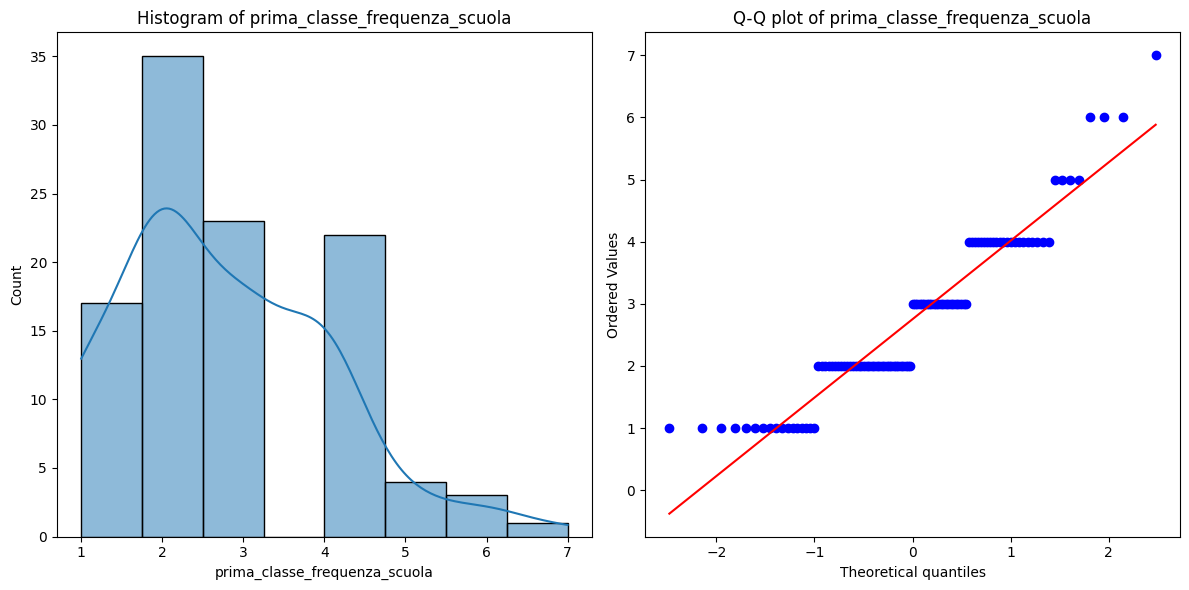

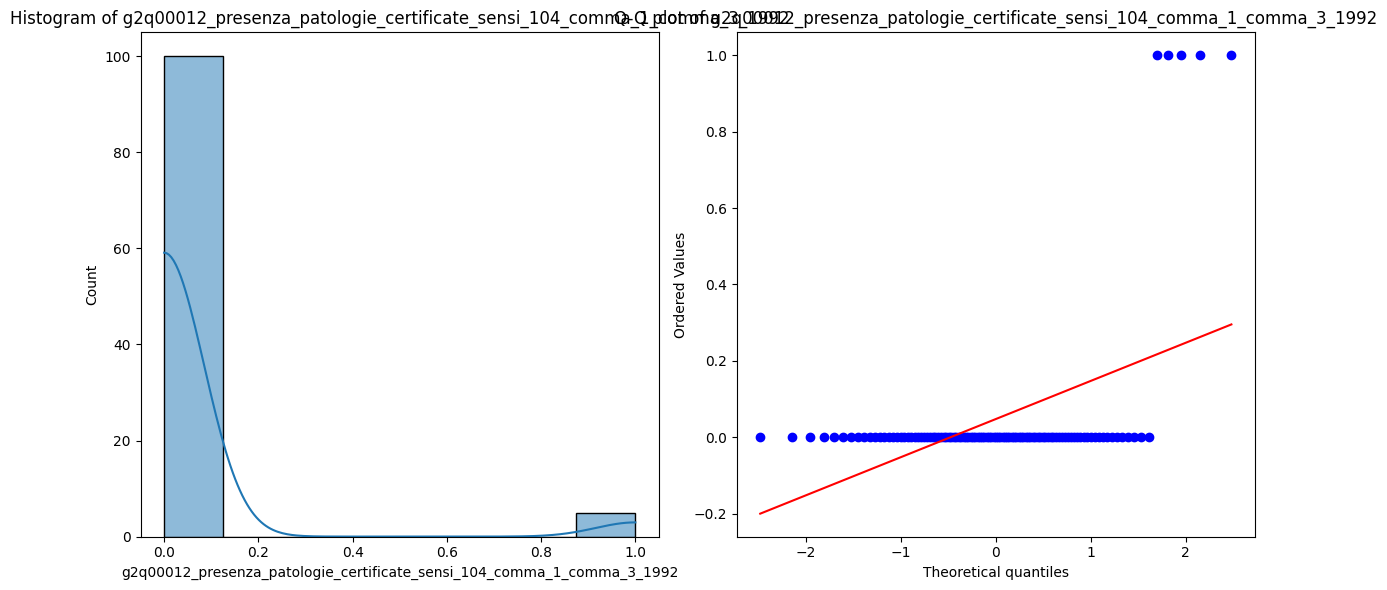

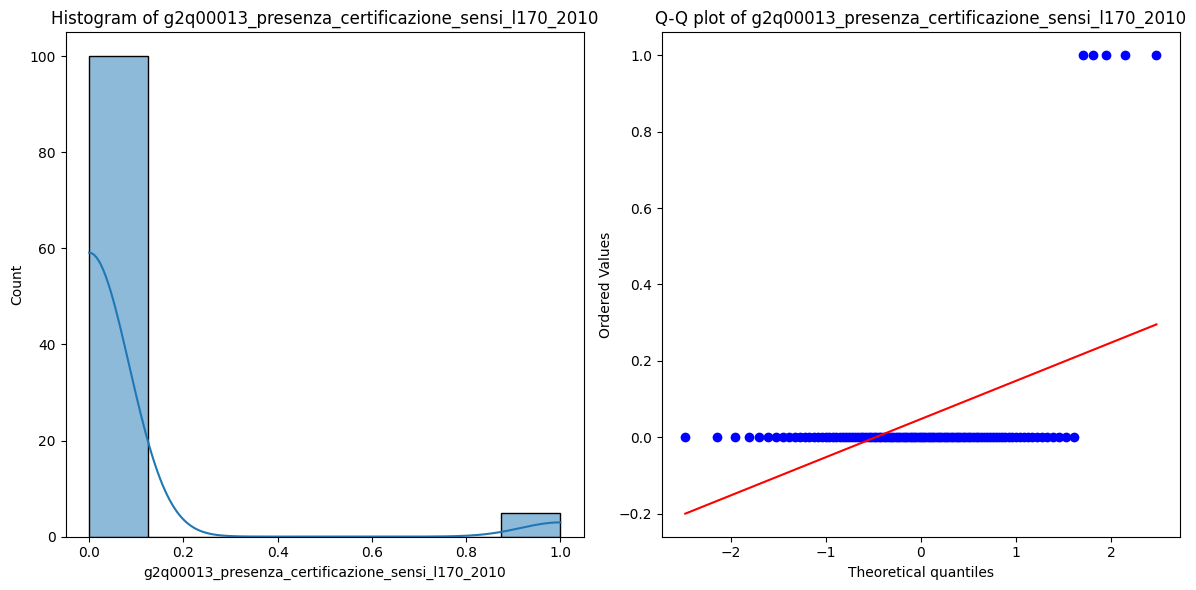

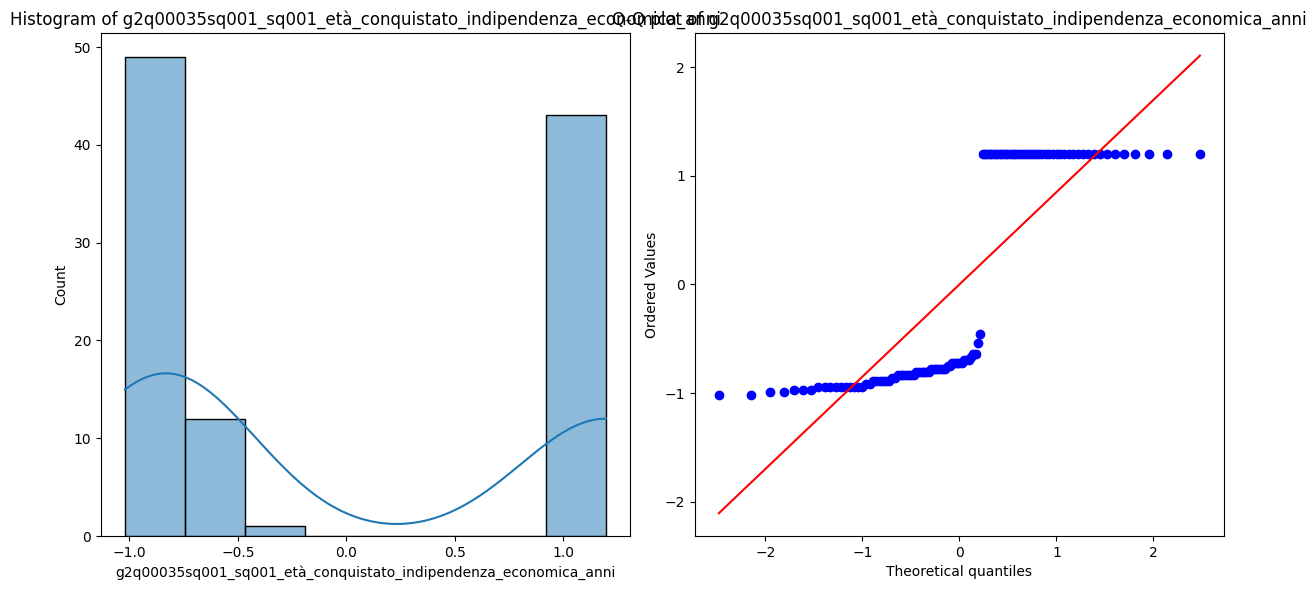

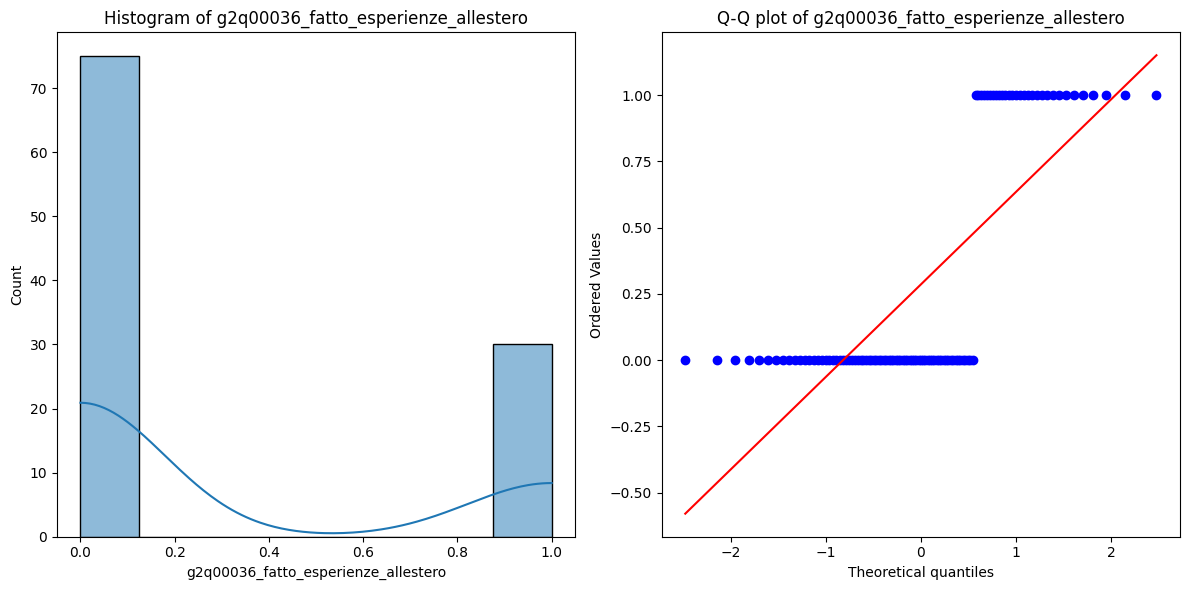

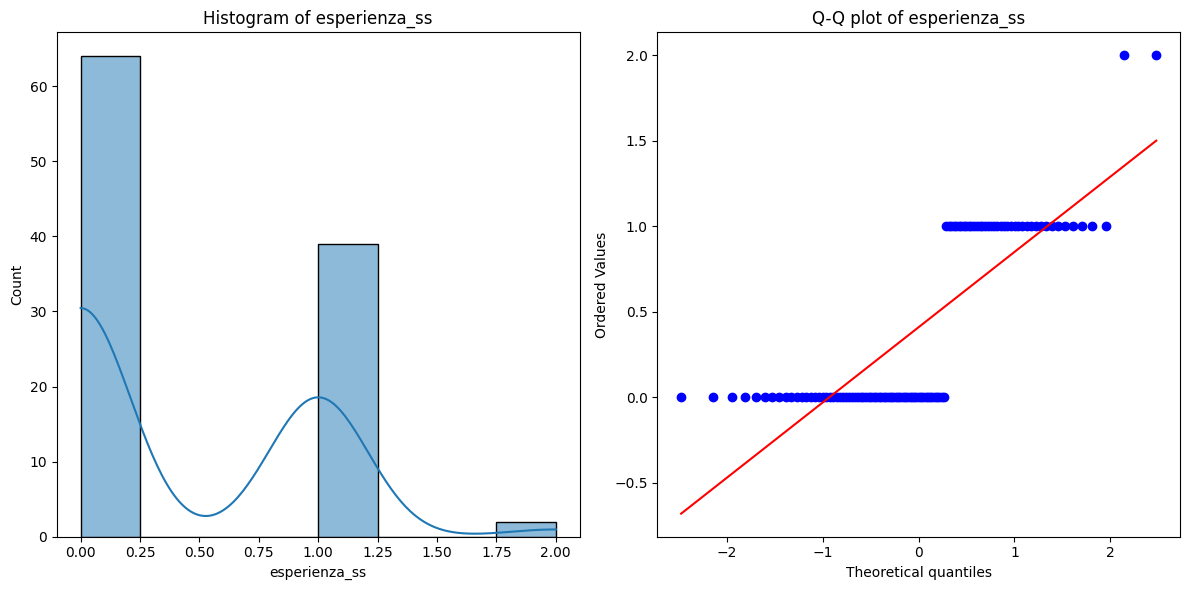

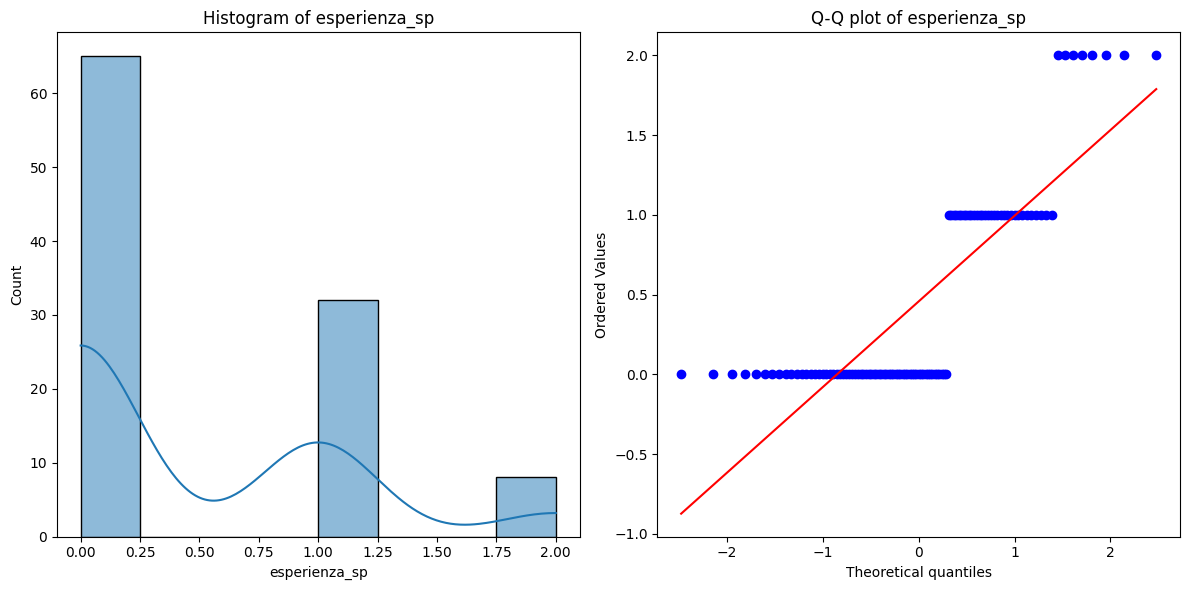

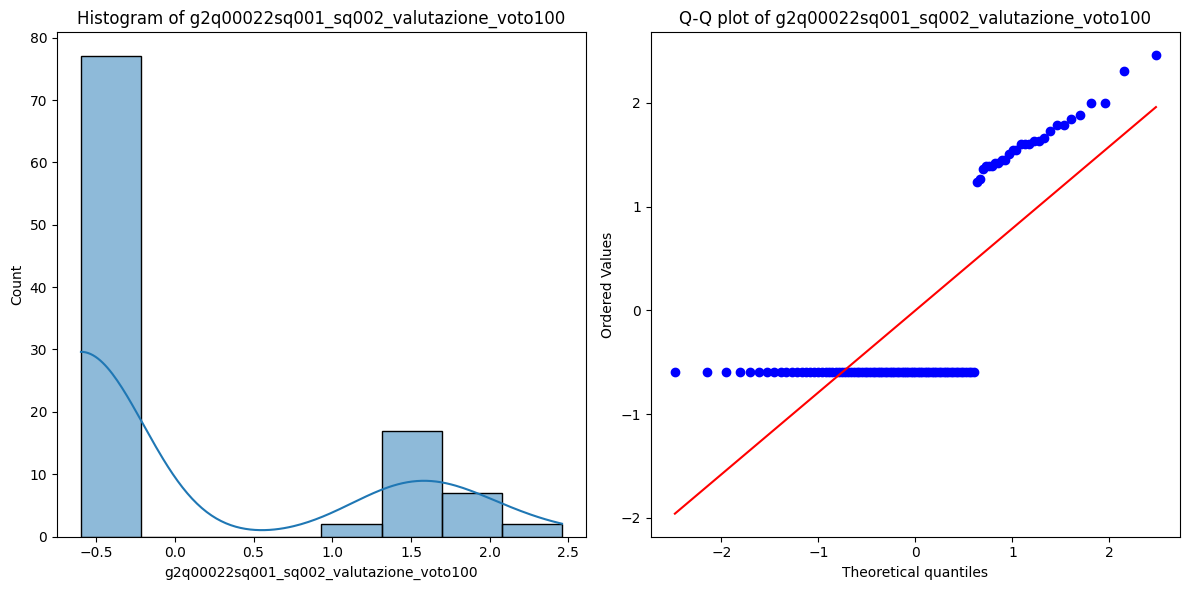

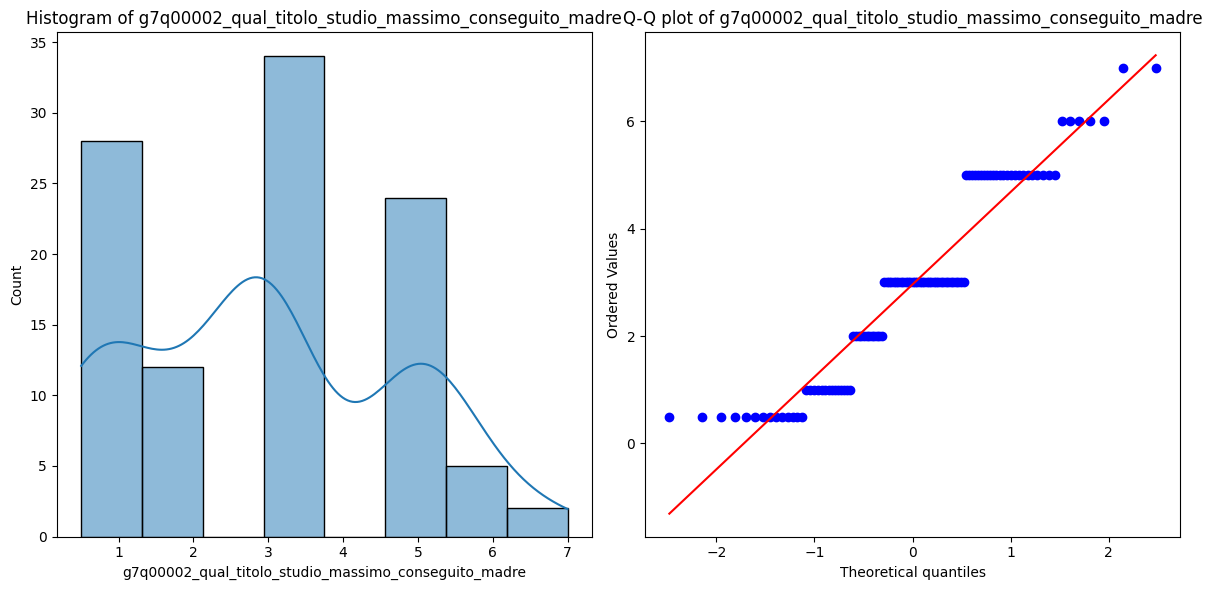

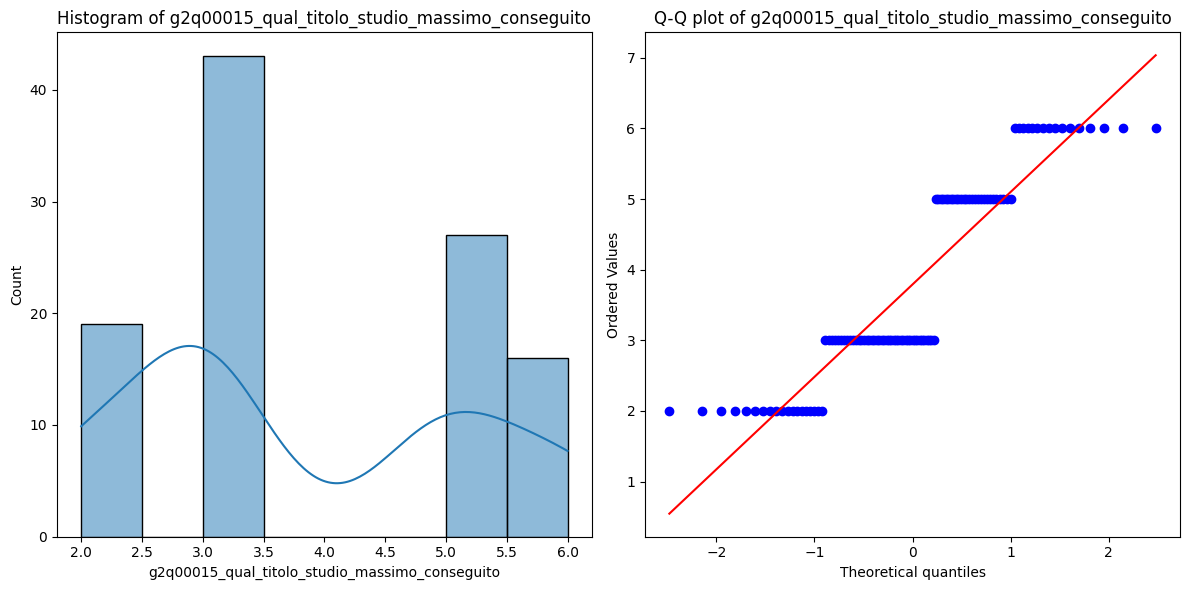

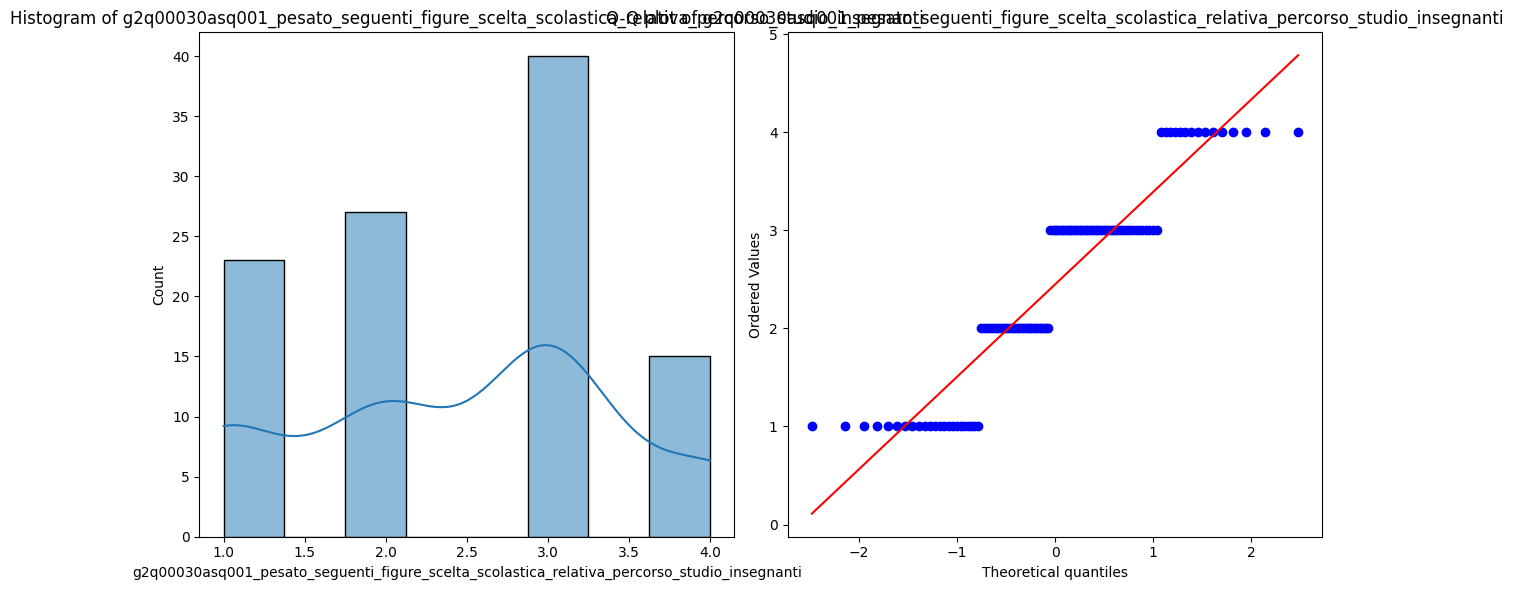

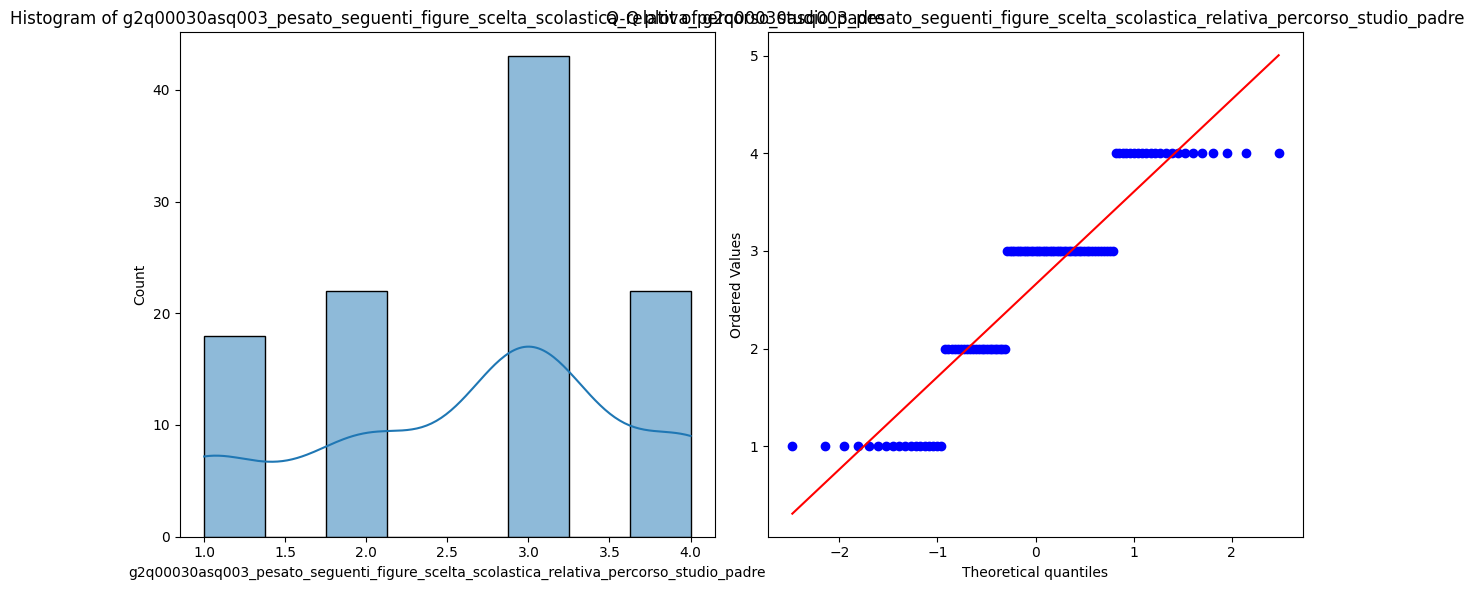

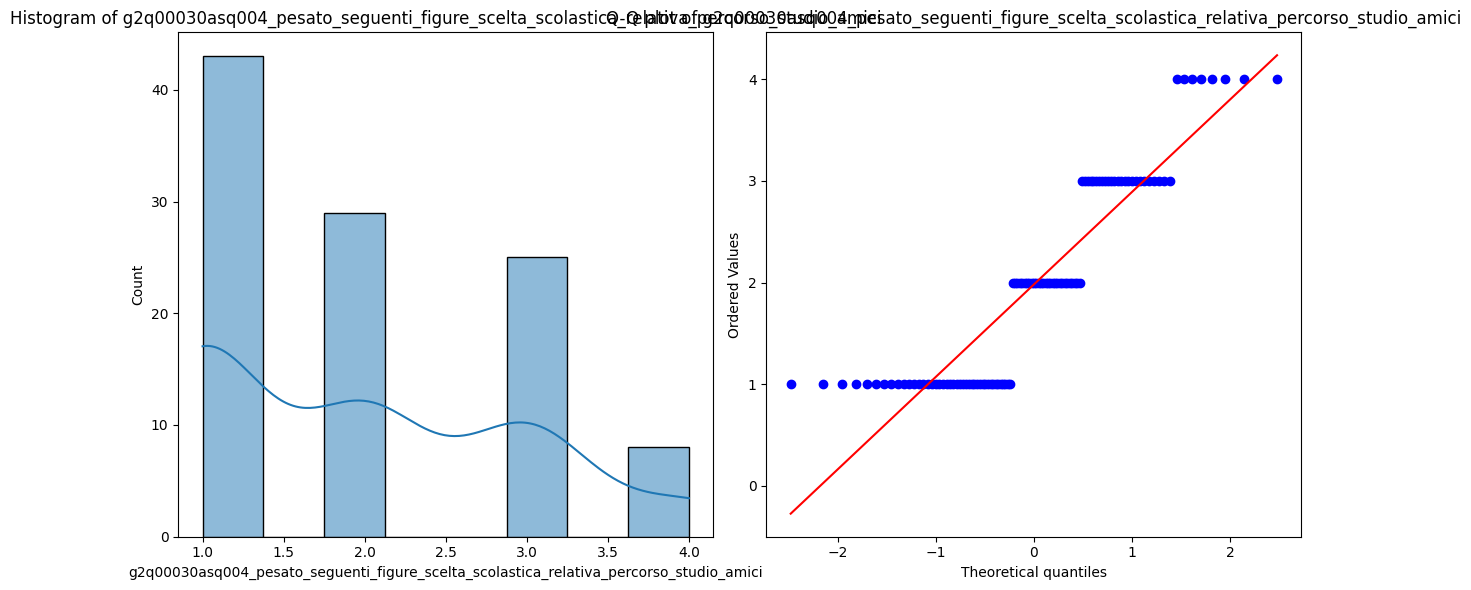

In [55]:
from scipy import stats

for col in df_cleaned.columns:
    # Histogram
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(df_cleaned[col], kde=True)
    plt.title(f'Histogram of {col}')

    # Q-Q plot
    plt.subplot(1, 2, 2)
    stats.probplot(df_cleaned[col], dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {col}')

    plt.tight_layout()
    plt.show()

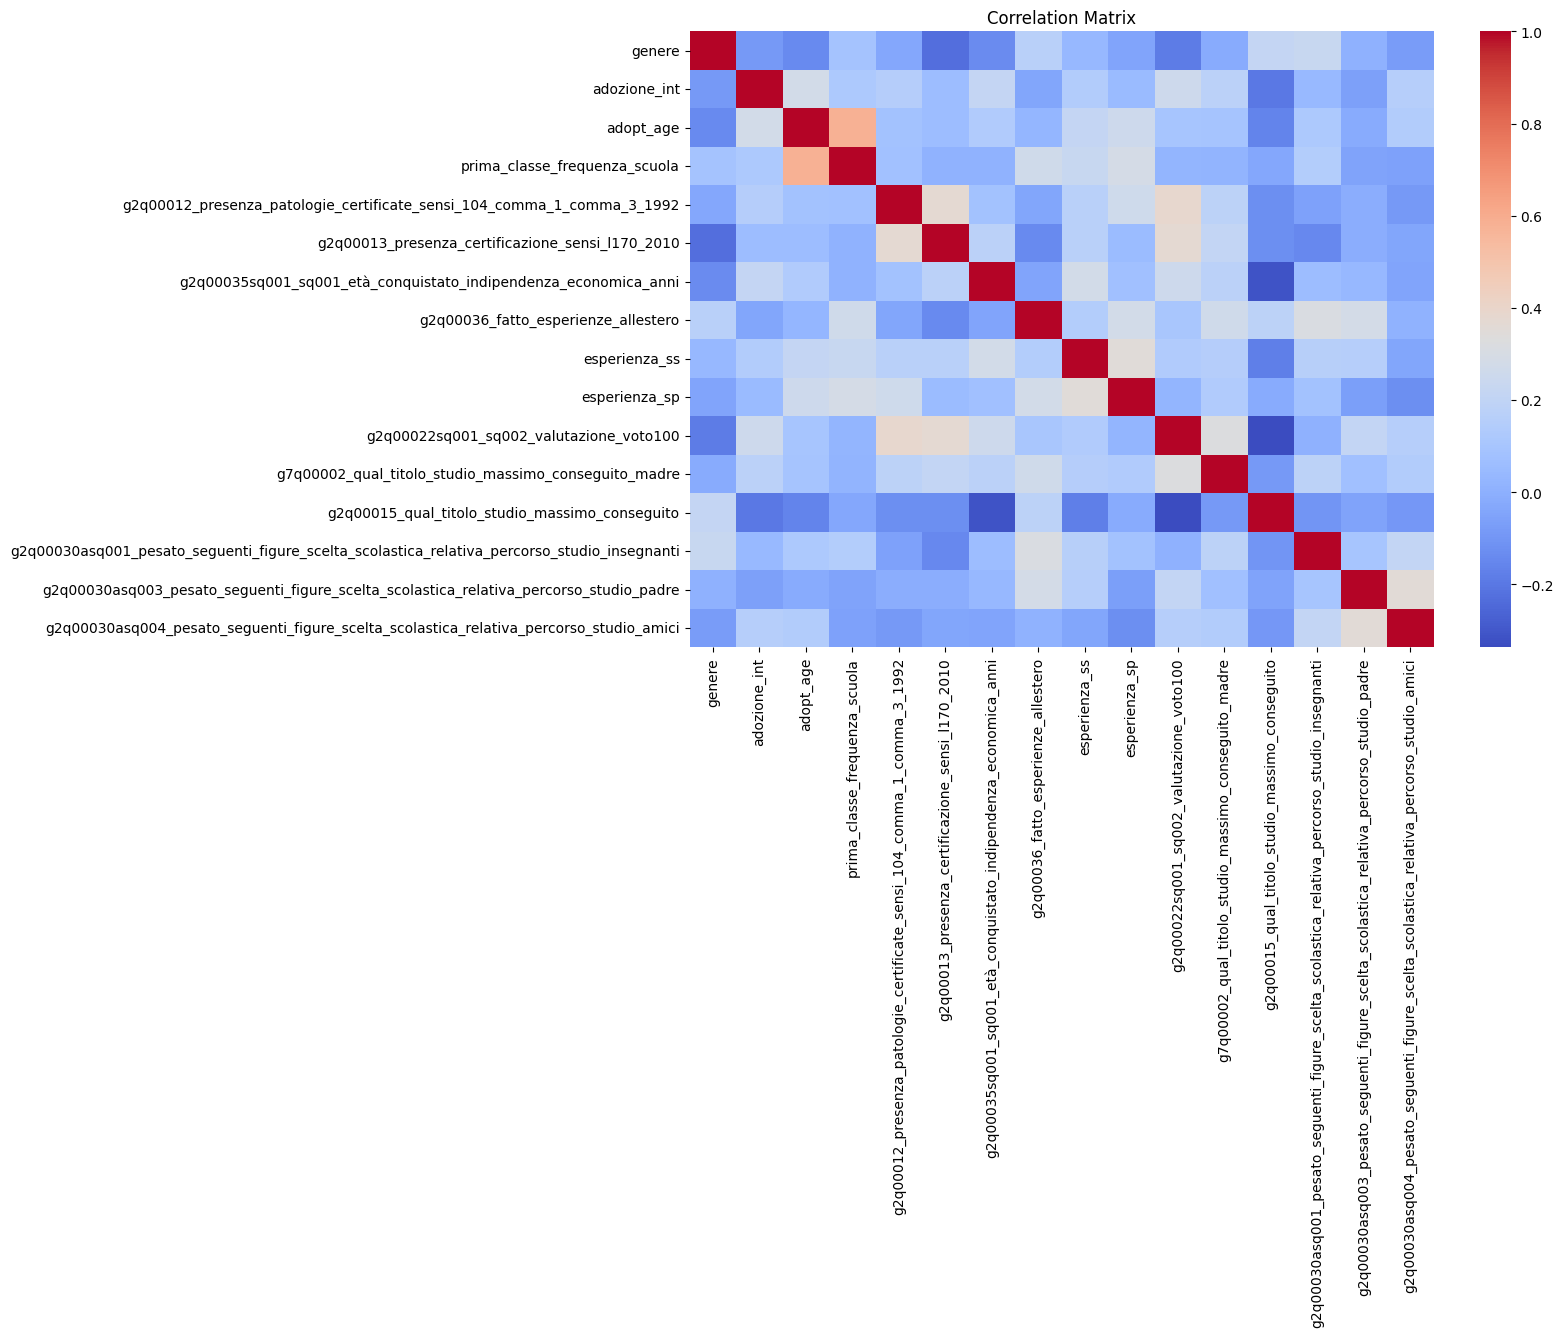

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(df_cleaned.corr(), cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()

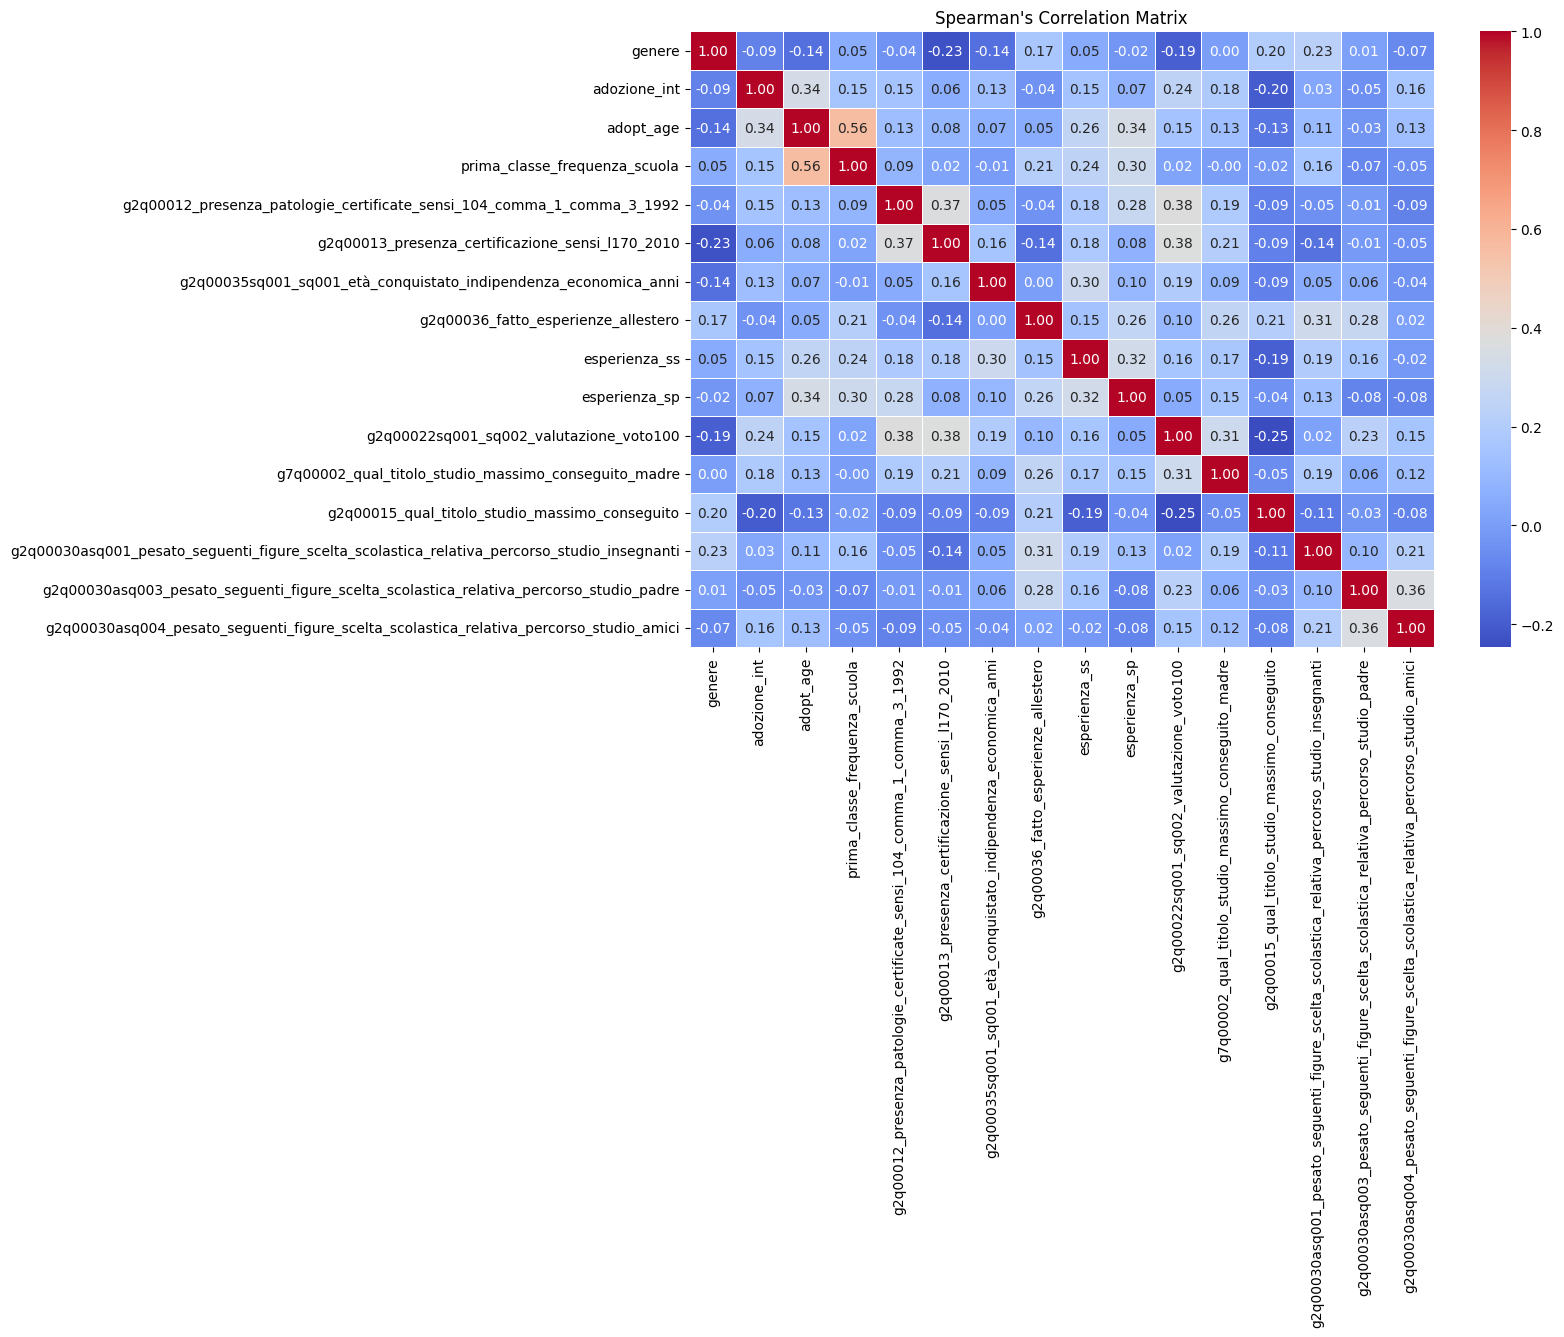

In [57]:
spearman_corr = df_cleaned.corr(method="spearman")

# Plot Spearman's correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(spearman_corr, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)
plt.title("Spearman's Correlation Matrix")
plt.show()

In [58]:
from scipy.stats import chi2_contingency

categorical_vars = [col for col in categorical_vars if col in df_cleaned.columns]
for cat_var in categorical_vars:
    try:
        contingency_table = pd.crosstab(df_cleaned[cat_var], df_cleaned[target_variable])
        stat, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"Chi-Square Test for Independence between {target_variable} and {cat_var}:")
        print(f"Statistic: {stat}, p-value: {p_value}, Degrees of Freedom: {dof}\n")
    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and genere:
Statistic: 6.636914457501241, p-value: 0.08441653507295305, Degrees of Freedom: 3

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and adozione_int:
Statistic: 6.345512673398613, p-value: 0.09595831315090646, Degrees of Freedom: 3

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and prima_classe_frequenza_scuola:
Statistic: 12.514055634590495, p-value: 0.8195949416691728, Degrees of Freedom: 18

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992:
Statistic: 7.569767441860465, p-value: 0.05579266739817207, Degrees of Freedom: 3

Chi-Square Test for Independence between g2q00015_qual_titolo_studio_massimo_conseguito and g2q00013_presenza_certificazione_sensi_l170_2010:
Statistic: 7.569767441860465, p-

In [59]:
import scipy.stats as stats

for cat_var in categorical_vars:
    try:
        groups = [df_cleaned[df_cleaned[cat_var] == val][target_variable].dropna()
                  for val in df_cleaned[cat_var].unique()]

        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            kruskal_stat, kruskal_p_value = stats.kruskal(*groups)

            print(f"Kruskal-Wallis test result for {target_variable} by {cat_var}:")
            print(f"Statistic: {kruskal_stat}, p-value: {kruskal_p_value}\n")
        else:
            print(f"Skipping {cat_var} - Not enough valid groups for Kruskal-Wallis test.")

    except KeyError:
        print(f"Skipping {cat_var} - column not found in df_cleaned.")

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by genere:
Statistic: 4.0774309045936015, p-value: 0.04345968967156473

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by adozione_int:
Statistic: 4.227159468438601, p-value: 0.03978196608243226

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by prima_classe_frequenza_scuola:
Statistic: 3.2862456091279335, p-value: 0.7721567658130325

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992:
Statistic: 0.9007217321571829, p-value: 0.34258826194034414

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by g2q00013_presenza_certificazione_sensi_l170_2010:
Statistic: 0.9007217321571829, p-value: 0.34258826194034414

Kruskal-Wallis test result for g2q00015_qual_titolo_studio_massimo_conseguito by g2q00036_fatto_esperienze_allestero:

In [60]:
pip install imbalanced-learn


In [61]:
smote = SMOTE(k_neighbors=1, random_state=42)
smote_tomek = SMOTETomek(smote=smote, random_state=42)
X_resampled, y_resampled = smote_tomek.fit_resample(X_train, y_train)
class_counts_resampled = pd.Series(y_resampled).value_counts()
class_counts_resampled

,count
g2q00015_qual_titolo_studio_massimo_conseguito,
6,35
5,35
3,34
2,34


In [62]:
resampled_df = pd.DataFrame(X_resampled, columns=X.columns)
resampled_df["g2q00015_qual_titolo_studio_massimo_conseguito"] = y_resampled
resampled_df.head()

,genere,adozione_int,adopt_age,prima_classe_frequenza_scuola,g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992,g2q00013_presenza_certificazione_sensi_l170_2010,g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni,g2q00036_fatto_esperienze_allestero,esperienza_ss,esperienza_sp,g2q00022sq001_sq002_valutazione_voto100,g8q00002_qual_titolo_studio_massimo_conseguito_padre,g7q00002_qual_titolo_studio_massimo_conseguito_madre,g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti,g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre,g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre,g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici,g2q00015_qual_titolo_studio_massimo_conseguito
0,1,0,-1.091008,1,0,0,-0.750645,0.0,0,0,-0.596372,1.0,0.5,1,1,1,1,6
1,0,1,0.034848,1,0,0,1.196140,1.0,0,1,1.542884,7.0,7.0,3,1,1,1,3
2,0,1,-0.809544,1,0,1,1.196140,0.0,1,0,2.001296,3.0,6.0,1,4,4,1,3
3,0,1,2.005095,2,0,0,-0.777684,0.0,0,0,-0.596372,3.0,6.0,2,4,3,4,6
4,1,0,1.442167,6,0,0,-0.831762,1.0,0,1,-0.596372,3.0,6.0,4,4,3,3,6


In [63]:
resampled_df.columns.tolist()

['genere',
 'adozione_int',
 'adopt_age',
 'prima_classe_frequenza_scuola',
 'g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992',
 'g2q00013_presenza_certificazione_sensi_l170_2010',
 'g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni',
 'g2q00036_fatto_esperienze_allestero',
 'esperienza_ss',
 'esperienza_sp',
 'g2q00022sq001_sq002_valutazione_voto100',
 'g8q00002_qual_titolo_studio_massimo_conseguito_padre',
 'g7q00002_qual_titolo_studio_massimo_conseguito_madre',
 'g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti',
 'g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre',
 'g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre',
 'g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici',
 'g2q00015_qual_titolo_studio_massimo_conseguito']

## Regressions


In [64]:
X_train, y_train = X_resampled, y_resampled

In [65]:
if 'Intercept' in X_train.columns:
    X_train = X_train.drop(columns=['Intercept'])
model_ord = OrderedModel(y_train, X_train, distr='logit')
results = model_ord.fit(maxiter=15000, method='bfgs')
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.156316
         Iterations: 74
         Function evaluations: 76
         Gradient evaluations: 76
                                           OrderedModel Results                                           
Dep. Variable:     g2q00015_qual_titolo_studio_massimo_conseguito   Log-Likelihood:                -159.57
Model:                                               OrderedModel   AIC:                             359.1
Method:                                        Maximum Likelihood   BIC:                             417.7
Date:                                            Mon, 17 Feb 2025                                         
Time:                                                    01:26:08                                         
No. Observations:                                             138                                         
Df Residuals:                                                 118              

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from statsmodels.miscmodels.ordinal_model import OrderedModel


y_train_pred = results.predict(X_train).idxmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)


y_test_pred = results.predict(X_test).idxmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Confusion Matrix:
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [3 0 0 1 0 0]
 [3 0 4 1 0 0]
 [1 2 2 1 0 0]
 [0 1 0 2 0 0]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         0
     Class 1       0.00      0.00      0.00         0
     Class 2       0.00      0.00      0.00         4
     Class 3       0.20      0.12      0.15         8
     Class 5       0.00      0.00      0.00         6
     Class 6       0.00      0.00      0.00         3

    accuracy                           0.05        21
   macro avg       0.03      0.02      0.03        21
weighted avg       0.08      0.05      0.06        21

Evaluation Results:
Training Accuracy: 0.0942
Test Accuracy: 0.0476
Training MAE: 2.4565
Test MAE: 2.4762


In [67]:
selected_features = [
    "genere",
    "adozione_int",
    "adopt_age",
    "prima_classe_frequenza_scuola",
    "g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    "g2q00013_presenza_certificazione_sensi_l170_2010",
    "g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni",
    "g2q00036_fatto_esperienze_allestero",
    "esperienza_sp",
    "g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre",
    "g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici"
]

X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]
if 'Intercept' in X.columns:
    X = X.drop(columns=['Intercept'])

model_ord = OrderedModel(y_train, X_train_selected, distr='logit')
results = model_ord.fit(maxiter=15000)
print(results.summary())

Optimization terminated successfully.
         Current function value: 1.210870
         Iterations: 2231
         Function evaluations: 2980
                                           OrderedModel Results                                           
Dep. Variable:     g2q00015_qual_titolo_studio_massimo_conseguito   Log-Likelihood:                -167.10
Model:                                               OrderedModel   AIC:                             362.2
Method:                                        Maximum Likelihood   BIC:                             403.2
Date:                                            Mon, 17 Feb 2025                                         
Time:                                                    01:26:11                                         
No. Observations:                                             138                                         
Df Residuals:                                                 124                                         
Df

In [68]:
y_train_pred = results.predict(X_train_selected).idxmax(axis=1)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)


y_test_pred = results.predict(X_test_selected).idxmax(axis=1)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")

Confusion Matrix:
 [[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [2 1 0 1 0 0]
 [4 0 1 3 0 0]
 [2 1 2 1 0 0]
 [0 0 1 2 0 0]]

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         0
     Class 1       0.00      0.00      0.00         0
     Class 2       0.00      0.00      0.00         4
     Class 3       0.43      0.38      0.40         8
     Class 5       0.00      0.00      0.00         6
     Class 6       0.00      0.00      0.00         3

    accuracy                           0.14        21
   macro avg       0.07      0.06      0.07        21
weighted avg       0.16      0.14      0.15        21

Evaluation Results:
Training Accuracy: 0.0942
Test Accuracy: 0.1429
Training MAE: 2.5145
Test MAE: 2.4286


In [69]:
## multiclass
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
import numpy as np

log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', penalty='l2', random_state=42, max_iter=10000)
log_reg.fit(X_train, y_train)

y_train_pred = log_reg.predict(X_train)
y_test_pred = log_reg.predict(X_test)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)

test_accuracy = accuracy_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

unique_classes = np.unique(np.concatenate([y_test, y_test_pred]))
conf_matrix = confusion_matrix(y_test, y_test_pred, labels=unique_classes)
class_report = classification_report(
    y_test, y_test_pred, labels=unique_classes, target_names=[f"Class {i}" for i in unique_classes], zero_division=0
)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", class_report)
print("Evaluation Results:")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Training MAE: {train_mae:.4f}")
print(f"Test MAE: {test_mae:.4f}")


Confusion Matrix:
 [[2 1 1 0]
 [0 7 0 1]
 [0 3 3 0]
 [1 0 0 2]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.67      0.50      0.57         4
     Class 3       0.64      0.88      0.74         8
     Class 5       0.75      0.50      0.60         6
     Class 6       0.67      0.67      0.67         3

    accuracy                           0.67        21
   macro avg       0.68      0.64      0.64        21
weighted avg       0.68      0.67      0.66        21

Evaluation Results:
Training Accuracy: 0.7609
Test Accuracy: 0.6667
Training MAE: 0.5290
Test MAE: 0.8095


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [70]:
from sklearn.inspection import permutation_importance

# Compute permutation importance
perm_importance = permutation_importance(log_reg, X_test, y_test, n_repeats=10, random_state=42)
perm_importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)
print("\nPermutation Importance:\n")
print(perm_importance_df)


Permutation Importance:

                                              Feature  Importance
10            g2q00022sq001_sq002_valutazione_voto100    0.319048
13  g2q00030asq001_pesato_seguenti_figure_scelta_s...    0.109524
3                       prima_classe_frequenza_scuola    0.104762
11  g8q00002_qual_titolo_studio_massimo_conseguito...    0.095238
7                 g2q00036_fatto_esperienze_allestero    0.090476
15  g2q00030asq003_pesato_seguenti_figure_scelta_s...    0.047619
14  g2q00030asq002_pesato_seguenti_figure_scelta_s...    0.038095
12  g7q00002_qual_titolo_studio_massimo_conseguito...    0.038095
6   g2q00035sq001_sq001_età_conquistato_indipenden...    0.033333
1                                        adozione_int    0.028571
8                                       esperienza_ss    0.000000
4   g2q00012_presenza_patologie_certificate_sensi_...    0.000000
5    g2q00013_presenza_certificazione_sensi_l170_2010    0.000000
9                                       esperienza

In [71]:
feature_importance_per_class = pd.DataFrame(log_reg.coef_, columns=X_train.columns)
feature_importance_per_class.index = [f"Class {cls}" for cls in log_reg.classes_]
print("\nFeature Importance Per Class (Coefficients):\n")
print(feature_importance_per_class)


Feature Importance Per Class (Coefficients):

           genere  adozione_int  adopt_age  prima_classe_frequenza_scuola  \
Class 2 -0.200632      0.406067   0.747595                      -0.486284   
Class 3 -0.624663     -0.256875  -0.910831                       0.724562   
Class 5  0.861378      0.757072   0.062258                      -0.266011   
Class 6 -0.036084     -0.906263   0.100979                       0.027734   

         g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992  \
Class 2                                          -0.010405                        
Class 3                                           0.056490                        
Class 5                                          -0.041425                        
Class 6                                          -0.004661                        

         g2q00013_presenza_certificazione_sensi_l170_2010  \
Class 2                                         -0.043455   
Class 3                      

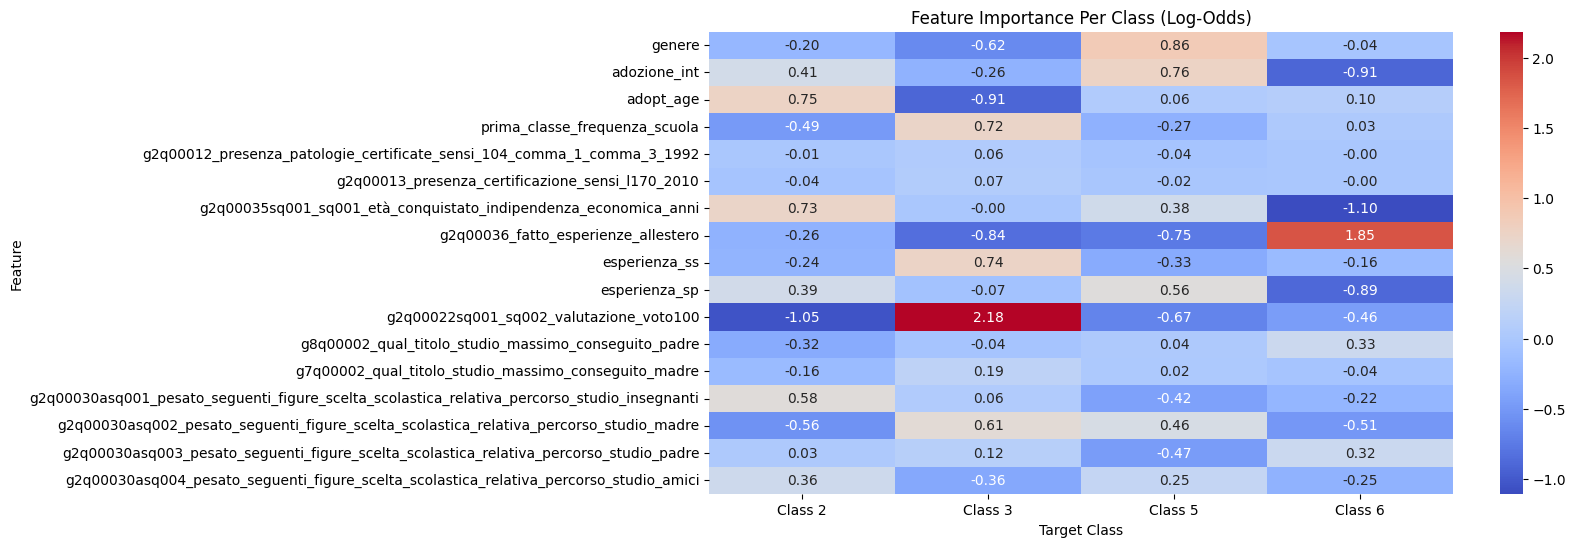

In [72]:
plt.figure(figsize=(12, 6))
sns.heatmap(feature_importance_per_class.T, cmap="coolwarm", annot=True, fmt=".2f")
plt.title("Feature Importance Per Class (Log-Odds)")
plt.xlabel("Target Class")
plt.ylabel("Feature")
plt.show()

In [73]:
model_eqn = f"g2q00015_qual_titolo_studio_massimo_conseguito ~ " + " + ".join(X_train.columns)
model = sm.MNLogit.from_formula(model_eqn, resampled_df).fit_regularized(
    method="l1", alpha=0.5, maxiter=18000, cov_type="HC3"
)
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.7326751146296532
            Iterations: 196
            Function evaluations: 199
            Gradient evaluations: 196


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        MNLogit Regression Results                                        
==========================================================================================================
Dep. Variable:     g2q00015_qual_titolo_studio_massimo_conseguito   No. Observations:                  138
Model:                                                    MNLogit   Df Residuals:                      100
Method:                                                       MLE   Df Model:                           35
Date:                                            Mon, 17 Feb 2025   Pseudo R-squ.:                  0.5555
Time:                                                    01:26:15   Log-Likelihood:                -85.033
converged:                                                   True   LL-Null:                       -191.29
Covariance Type:                                              HC3   LLR p-value:                 2.668e-27
===============================================================================================================================================================
                                           g2q00015_qual_titolo_studio_massimo_conseguito=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      -2.0938      1.518     -1.379      0.168      -5.070       0.882
genere                                                                                         -0.5278      0.925     -0.571      0.568      -2.340       1.284
adozione_int                                                                                   -0.7415      1.331     -0.557      0.577      -3.350       1.867
adopt_age                                                                                      -1.7516      0.570     -3.075      0.002      -2.868      -0.635
prima_classe_frequenza_scuola                                                                   0.9604      0.400      2.398      0.016       0.175       1.745
g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992                               0      1.823          0      1.000      -3.574       3.574
g2q00013_presenza_certificazione_sensi_l170_2010                                                     0      1.580          0      1.000      -3.098       3.098
g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni                                -0.7125      0.399     -1.784      0.074      -1.495       0.070
g2q00036_fatto_esperienze_allestero                                                            -0.2099      1.416     -0.148      0.882      -2.984       2.564
esperienza_ss                                                                                   1.3335      0.917      1.454      0.146      -0.464       3.131
esperienza_sp                                                                                  -0.1285      0.609     -0.211      0.833      -1.322       1.065
g2q00022sq001_sq002_valutazione_voto100                                                         4.6032      0.702      6.556      0.000       3.227       5.979
g8q00002_qual_titolo_studio_massimo_conseguito_padre                                            0.0596      0.252      0.236      0.813      -0.435       0.554
g7q00002_qual_titolo_studio_massimo_conseguito_madre                                            0.2813      0.437      0.643      0.520      -0.576       1.138
g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti    -0.4605      0.384     -1.200      0.230      -1.213       0.292
g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre          1.0985      0

In [92]:
model_eqn = "g2q00015_qual_titolo_studio_massimo_conseguito ~ " + " + ".join([
    "adopt_age",
    "esperienza_ss",
    "g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    'g2q00013_presenza_certificazione_sensi_l170_2010',
    "esperienza_sp",
    "genere",
    "g2q00036_fatto_esperienze_allestero",
    "g8q00002_qual_titolo_studio_massimo_conseguito_padre",
    "adozione_int",
    "genere * adozione_int",
    "adozione_int * prima_classe_frequenza_scuola",
    'g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti',
       'g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre',
       'g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici'
])
model = sm.MNLogit.from_formula(model_eqn, resampled_df).fit_regularized(
    method="l1", alpha=0.5, maxiter=18000, cov_type="HC3"
)
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.9960531400817288
            Iterations: 192
            Function evaluations: 194
            Gradient evaluations: 192


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        MNLogit Regression Results                                        
==========================================================================================================
Dep. Variable:     g2q00015_qual_titolo_studio_massimo_conseguito   No. Observations:                  138
Model:                                                    MNLogit   Df Residuals:                      100
Method:                                                       MLE   Df Model:                           35
Date:                                            Mon, 17 Feb 2025   Pseudo R-squ.:                  0.3761
Time:                                                    01:31:35   Log-Likelihood:                -119.35
converged:                                                   True   LL-Null:                       -191.29
Covariance Type:                                              HC3   LLR p-value:                 3.741e-15
===============================================================================================================================================================
                                           g2q00015_qual_titolo_studio_massimo_conseguito=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      -3.8128      1.144     -3.333      0.001      -6.055      -1.571
adopt_age                                                                                      -0.9533      0.414     -2.304      0.021      -1.764      -0.143
esperienza_ss                                                                                   0.4983      0.600      0.831      0.406      -0.677       1.673
g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992                          3.5740      1.116      3.202      0.001       1.386       5.762
g2q00013_presenza_certificazione_sensi_l170_2010                                                2.4694      1.097      2.251      0.024       0.320       4.619
esperienza_sp                                                                                  -0.9243      0.470     -1.966      0.049      -1.846      -0.003
genere                                                                                         -0.5900      0.798     -0.740      0.460      -2.153       0.973
g2q00036_fatto_esperienze_allestero                                                             0.4470      0.758      0.590      0.556      -1.039       1.933
g8q00002_qual_titolo_studio_massimo_conseguito_padre                                            0.4642      0.216      2.152      0.031       0.041       0.887
adozione_int                                                                                    3.5086      1.632      2.149      0.032       0.309       6.708
genere:adozione_int                                                                            -0.6887      1.126     -0.612      0.541      -2.895       1.517
prima_classe_frequenza_scuola                                                                   1.1219      0.399      2.811      0.005       0.340       1.904
adozione_int:prima_classe_frequenza_scuola                                                     -1.1233      0.505     -2.225      0.026      -2.113      -0.134
g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti    -0.7192      0.298     -2.413      0.016      -1.303      -0.135
g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre          0.6447      0.289      2.231      0.026       0.078       1.211
g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici          0.0188      0

In [93]:
model_eqn = "g2q00015_qual_titolo_studio_massimo_conseguito ~ " + " + ".join([
    "adopt_age",
    "g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992",
    'g2q00013_presenza_certificazione_sensi_l170_2010',
    "g2q00036_fatto_esperienze_allestero",
    "adozione_int",
    "genere * adozione_int",
    "adozione_int * prima_classe_frequenza_scuola",
    'g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti',
       'g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre',
])
model = sm.MNLogit.from_formula(model_eqn, resampled_df).fit_regularized(
    method="l1", alpha=0.5, maxiter=18000, cov_type="HC3"
)
model.summary()

Optimization terminated successfully    (Exit mode 0)
            Current function value: 1.074830773691749
            Iterations: 156
            Function evaluations: 156
            Gradient evaluations: 156


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        MNLogit Regression Results                                        
==========================================================================================================
Dep. Variable:     g2q00015_qual_titolo_studio_massimo_conseguito   No. Observations:                  138
Model:                                                    MNLogit   Df Residuals:                      112
Method:                                                       MLE   Df Model:                           23
Date:                                            Mon, 17 Feb 2025   Pseudo R-squ.:                  0.2950
Time:                                                    01:31:40   Log-Likelihood:                -134.86
converged:                                                   True   LL-Null:                       -191.29
Covariance Type:                                              HC3   LLR p-value:                 7.823e-14
===============================================================================================================================================================
                                           g2q00015_qual_titolo_studio_massimo_conseguito=3       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      -3.2715      1.111     -2.944      0.003      -5.449      -1.094
adopt_age                                                                                      -0.9889      0.379     -2.607      0.009      -1.732      -0.245
g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992                          2.9227      1.191      2.454      0.014       0.589       5.257
g2q00013_presenza_certificazione_sensi_l170_2010                                                2.3787      1.102      2.159      0.031       0.219       4.538
g2q00036_fatto_esperienze_allestero                                                             0.2005      0.734      0.273      0.785      -1.238       1.639
adozione_int                                                                                    3.2068      1.802      1.780      0.075      -0.325       6.738
genere                                                                                         -0.3148      0.728     -0.432      0.665      -1.742       1.112
genere:adozione_int                                                                            -0.9018      1.031     -0.874      0.382      -2.923       1.120
prima_classe_frequenza_scuola                                                                   0.8644      0.375      2.307      0.021       0.130       1.599
adozione_int:prima_classe_frequenza_scuola                                                     -0.8030      0.507     -1.583      0.113      -1.797       0.191
g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti    -0.5561      0.303     -1.836      0.066      -1.150       0.037
g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre          0.8235      0.271      3.041      0.002       0.293       1.354
---------------------------------------------------------------------------------------------------------------------------------------------------------------
                                           g2q00015_qual_titolo_studio_massimo_conseguito=5       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                                      -0.3369      1

In [76]:
from catboost import CatBoostClassifier
cat_model = CatBoostClassifier(loss_function='MultiClass',
    iterations=600,
    depth=4,
    learning_rate=0.015,
    l2_leaf_reg=40,
    random_seed=42,
    early_stopping_rounds=18,
    random_strength=2,
    auto_class_weights="Balanced",
    bagging_temperature=1,
    verbose=False,
    eval_metric="TotalF1"   # focus on smaller classes
)

cat_model.fit(X_train, y_train)
y_train_pred_cat = cat_model.predict(X_train)
y_test_pred_cat = cat_model.predict(X_test)


train_accuracy_cat = accuracy_score(y_train, y_train_pred_cat)
test_accuracy_cat = accuracy_score(y_test, y_test_pred_cat)
train_mae_cat = mean_absolute_error(y_train, y_train_pred_cat)
test_mae_cat = mean_absolute_error(y_test, y_test_pred_cat)


conf_matrix_cat = confusion_matrix(y_test, y_test_pred_cat, labels=np.unique(y_test))
class_report_cat = classification_report(
    y_test, y_test_pred_cat, target_names=[f"Class {i}" for i in np.unique(y_test)], zero_division=0
)

print("\nCatBoost Results:")
print("Confusion Matrix:\n", conf_matrix_cat)
print("\nClassification Report:\n", class_report_cat)
print(f"Training Accuracy: {train_accuracy_cat:.4f}")
print(f"Test Accuracy: {test_accuracy_cat:.4f}")
print(f"Training MAE: {train_mae_cat:.4f}")
print(f"Test MAE: {test_mae_cat:.4f}")



CatBoost Results:
Confusion Matrix:
 [[4 0 0 0]
 [0 7 1 0]
 [1 0 4 1]
 [0 0 0 3]]

Classification Report:
               precision    recall  f1-score   support

     Class 2       0.80      1.00      0.89         4
     Class 3       1.00      0.88      0.93         8
     Class 5       0.80      0.67      0.73         6
     Class 6       0.75      1.00      0.86         3

    accuracy                           0.86        21
   macro avg       0.84      0.89      0.85        21
weighted avg       0.87      0.86      0.86        21

Training Accuracy: 0.8261
Test Accuracy: 0.8571
Training MAE: 0.3261
Test MAE: 0.2857


In [77]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(cat_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-validation accuracy: {np.mean(scores):.4f} ± {np.std(scores):.4f}")


Cross-validation accuracy: 0.7183 ± 0.0624


In [78]:
catboost_features = cat_model.feature_names_
feature_importances = cat_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': catboost_features,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)
feature_importance_df

,Feature,Importance
6,g2q00035sq001_sq001_età_conquistato_indipenden...,21.034189
10,g2q00022sq001_sq002_valutazione_voto100,18.048485
7,g2q00036_fatto_esperienze_allestero,12.744854
14,g2q00030asq002_pesato_seguenti_figure_scelta_s...,6.541691
15,g2q00030asq003_pesato_seguenti_figure_scelta_s...,6.388369
2,adopt_age,6.099850
9,esperienza_sp,4.580856
12,g7q00002_qual_titolo_studio_massimo_conseguito...,4.570136
11,g8q00002_qual_titolo_studio_massimo_conseguito...,3.701021
3,prima_classe_frequenza_scuola,2.986456


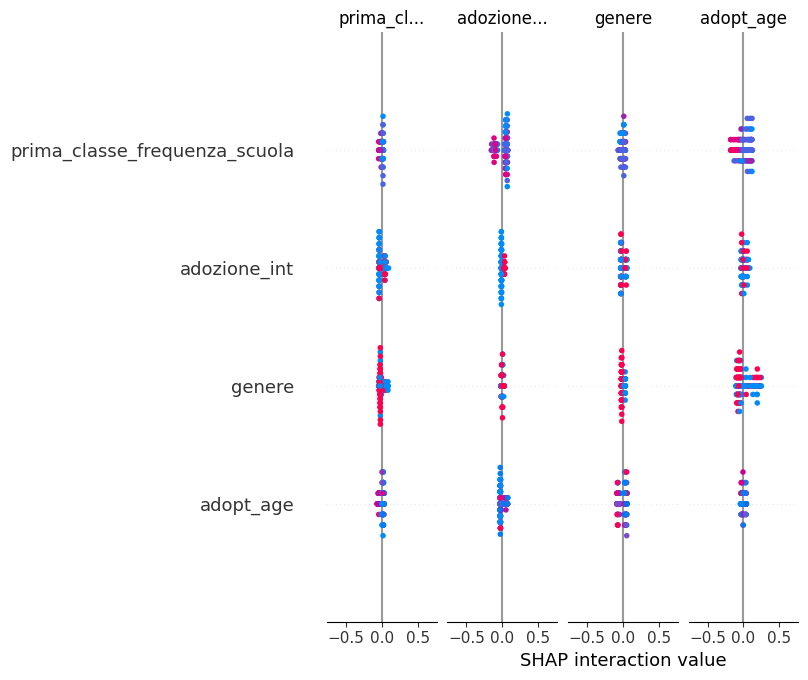

In [79]:
explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train)

Fitting 10 folds for each of 6 candidates, totalling 60 fits

Final Train ROC AUC: 0.8637
Final Test ROC AUC: 0.8837
Overfitting Gap (AUC): 0.02
Best Parameters: {'svm__C': 0.1, 'svm__kernel': 'linear'}


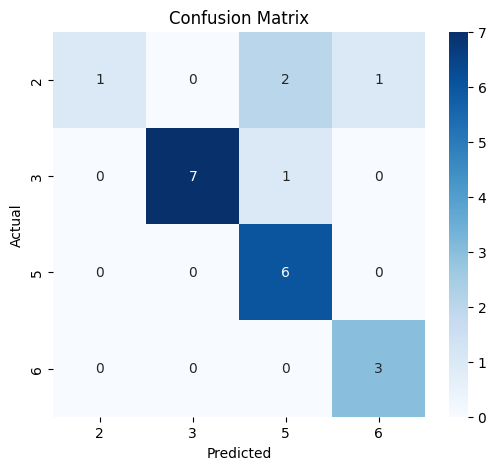


Classification Report:
               precision    recall  f1-score   support

     Class 2       1.00      0.25      0.40         4
     Class 3       1.00      0.88      0.93         8
     Class 5       0.67      1.00      0.80         6
     Class 6       0.75      1.00      0.86         3

    accuracy                           0.81        21
   macro avg       0.85      0.78      0.75        21
weighted avg       0.87      0.81      0.78        21


Per-Class Precision:  [1.    1.    0.667 0.75 ]
Per-Class Recall:  [0.25  0.875 1.    1.   ]
Per-Class F1 Score:  [0.4   0.933 0.8   0.857]

Weighted Precision:  0.869
Weighted Recall:  0.81
Weighted F1 Score:  0.783


In [130]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report,
    precision_recall_fscore_support
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

selector = SelectFromModel(SVC(kernel="linear", C=0.05, random_state=42))
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
selected_feature_names = X_train.columns[selector.get_support()]
pipeline = Pipeline([
    ('svm', SVC(probability=True, random_state=42, class_weight={2:5, 3:1, 4:10, 5:10, 6:10}))
])

param_grid = {
    'svm__C': [0.04, 0.08, 0.1],
    'svm__kernel': ['linear', 'rbf']
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=10, scoring='roc_auc_ovr',
    refit=True, n_jobs=-1, verbose=1
)

grid_search.fit(X_train_selected, y_train)
best_svm = grid_search.best_estimator_

y_train_proba = best_svm.predict_proba(X_train_selected)
y_test_proba = best_svm.predict_proba(X_test_selected)
train_auc = roc_auc_score(y_train, y_train_proba, multi_class='ovr')
test_auc = roc_auc_score(y_test, y_test_proba, multi_class='ovr')
overfitting_gap = abs(train_auc - test_auc)

print("\nFinal Train ROC AUC:", round(train_auc, 4))
print("Final Test ROC AUC:", round(test_auc, 4))
print("Overfitting Gap (AUC):", round(overfitting_gap, 4))
print("Best Parameters:", grid_search.best_params_)
y_pred = best_svm.predict(X_test_selected)
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=[f"Class {i}" for i in np.unique(y_test)], zero_division=0))
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, y_pred, average=None)
print("\nPer-Class Precision: ", np.round(precision, 3))
print("Per-Class Recall: ", np.round(recall, 3))
print("Per-Class F1 Score: ", np.round(f1_score, 3))

precision_w, recall_w, f1_w, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
print("\nWeighted Precision: ", round(precision_w, 3))
print("Weighted Recall: ", round(recall_w, 3))
print("Weighted F1 Score: ", round(f1_w, 3))

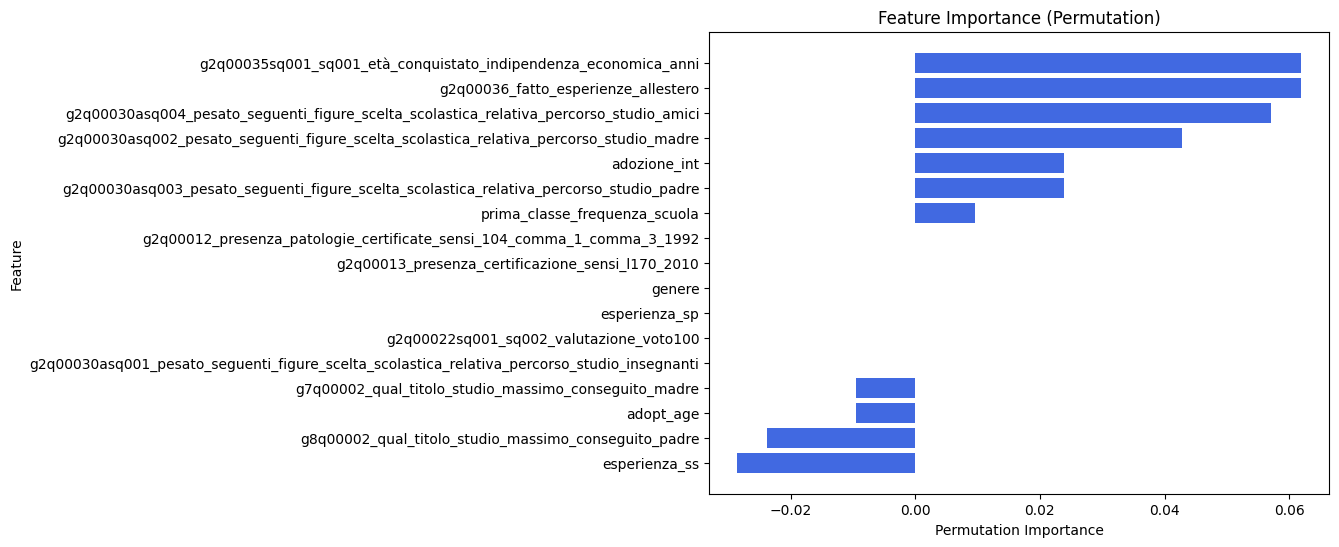

Feature Importance (Sorted):
g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni: 0.0619
g2q00036_fatto_esperienze_allestero: 0.0619
g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici: 0.0571
g2q00030asq002_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre: 0.0429
adozione_int: 0.0238
g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre: 0.0238
prima_classe_frequenza_scuola: 0.0095
g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992: 0.0000
g2q00013_presenza_certificazione_sensi_l170_2010: 0.0000
genere: 0.0000
esperienza_sp: 0.0000
g2q00022sq001_sq002_valutazione_voto100: 0.0000
g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti: 0.0000
g7q00002_qual_titolo_studio_massimo_conseguito_madre: -0.0095
adopt_age: -0.0095
g8q00002_qual_titolo_studio_massimo_conseguito_padre: -0.0238
esperienza_ss: -0.0286


In [131]:
from sklearn.inspection import permutation_importance
from sklearn.svm import SVC

svc = SVC(kernel='rbf', C=0.1)
svc.fit(X_train, y_train)

perm_importance = permutation_importance(svc, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42, n_jobs=-1)
feature_names = X_train.columns.to_list()
features = np.array(feature_names)
sorted_idx = perm_importance.importances_mean.argsort()
plt.figure(figsize=(8, 6))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], color='royalblue')
plt.xlabel("Permutation Importance")
plt.ylabel("Feature")
plt.title("Feature Importance (Permutation)")
plt.show()
sorted_importance = {features[i]: perm_importance.importances_mean[i] for i in sorted_idx[::-1]}
print("Feature Importance (Sorted):")
for feature, importance in sorted_importance.items():
    print(f"{feature}: {importance:.4f}")

In [83]:
df_cleaned.columns

Index(['genere', 'adozione_int', 'adopt_age', 'prima_classe_frequenza_scuola',
       'g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992',
       'g2q00013_presenza_certificazione_sensi_l170_2010',
       'g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni',
       'g2q00036_fatto_esperienze_allestero', 'esperienza_ss', 'esperienza_sp',
       'g2q00022sq001_sq002_valutazione_voto100',
       'g7q00002_qual_titolo_studio_massimo_conseguito_madre',
       'g2q00015_qual_titolo_studio_massimo_conseguito',
       'g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti',
       'g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre',
       'g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici'],
      dtype='object')

In [82]:
pip install semopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 7.7 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=1d4069a7f6d7f405adf0398c035396e487c644c61f2128c9d0b0d20fd3eec43d
  Stored in directory: /root/.cache/pip/wheels/d2/9a/31/fae291ff6a649bad125037eef8c7cc63d8c542e14bdcccea37
Successfully built semopy


In [119]:
from semopy import Model

sem_model_desc = """
# LV
personal_factors =~ genere + adozione_int + adopt_age
health_factors =~ g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992 + g2q00013_presenza_certificazione_sensi_l170_2010
family_support =~ g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti + g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_padre + g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici
education_exp =~ g2q00036_fatto_esperienze_allestero + esperienza_sp + prima_classe_frequenza_scuola

g2q00015_qual_titolo_studio_massimo_conseguito ~ personal_factors + family_support + education_exp + g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni
education_exp ~ health_factors + personal_factors
education_exp ~~  g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni

"""

sem_model = Model(sem_model_desc)
sem_model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
sem_model.inspect()


,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,education_exp,~,health_factors,-0.104866,0.106856,-0.981373,0.326409
1,education_exp,~,personal_factors,-1.584684,1.723823,-0.919285,0.357947
2,genere,~,personal_factors,1.000000,-,-,-
3,adozione_int,~,personal_factors,-2.873661,2.9385,-0.977935,0.328107
4,adopt_age,~,personal_factors,-14.127782,13.774168,-1.025672,0.305046
5,g2q00012_presenza_patologie_certificate_sensi_...,~,health_factors,1.000000,-,-,-
6,g2q00013_presenza_certificazione_sensi_l170_2010,~,health_factors,0.826081,0.535338,1.543102,0.122806
7,g2q00030asq001_pesato_seguenti_figure_scelta_s...,~,family_support,1.000000,-,-,-
8,g2q00030asq003_pesato_seguenti_figure_scelta_s...,~,family_support,1.322793,0.613023,2.15782,0.030942
9,g2q00030asq004_pesato_seguenti_figure_scelta_s...,~,family_support,2.229883,1.31362,1.69751,0.0896


In [120]:
from semopy import calc_stats

calc_stats(sem_model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,58,79,94.593712,0.001712,216.03898,0.732969,0.562145,0.403612,0.562145,0.636285,0.077888,63.839,151.419691,1.0805


In [86]:
sem_model_desc = """
personal_factors =~ genere + adozione_int + adopt_age
family_support =~ g2q00030asq001_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_insegnanti + g2q00030asq003_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_madre + g2q00030asq004_pesato_seguenti_figure_scelta_scolastica_relativa_percorso_studio_amici
education_exp =~ g2q00036_fatto_esperienze_allestero + g2q00022sq001_sq002_valutazione_voto100

g2q00015_qual_titolo_studio_massimo_conseguito ~ personal_factors + family_support + education_exp + g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni + g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992

personal_factors ~~ g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni
education_exp ~~ g2q00035sq001_sq001_età_conquistato_indipendenza_economica_anni + g2q00012_presenza_patologie_certificate_sensi_104_comma_1_comma_3_1992
"""

sem_model = Model(sem_model_desc)
sem_model.fit(df_cleaned, obj="DWLS", solver="SLSQP")
sem_model.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,genere,~,personal_factors,1.000000e+00,-,-,-
1,adozione_int,~,personal_factors,-1.529463e+00,0.676751,-2.26001,0.023821
2,adopt_age,~,personal_factors,-2.253815e+00,1.10649,-2.036905,0.04166
3,g2q00030asq003_pesato_seguenti_figure_scelta_s...,~,family_support,1.000000e+00,-,-,-
4,g2q00030asq004_pesato_seguenti_figure_scelta_s...,~,family_support,2.813341e+00,3.332771,0.844145,0.398589
5,g2q00036_fatto_esperienze_allestero,~,education_exp,1.000000e+00,-,-,-
6,g2q00022sq001_sq002_valutazione_voto100,~,education_exp,-1.014567e+01,8.677554,-1.169185,0.242329
7,g2q00015_qual_titolo_studio_massimo_conseguito,~,personal_factors,4.263525e+00,2.441716,1.746118,0.08079
8,g2q00015_qual_titolo_studio_massimo_conseguito,~,family_support,-1.038420e-01,0.551838,-0.188175,0.85074
9,g2q00015_qual_titolo_studio_massimo_conseguito,~,education_exp,-3.890129e+00,6.707795,-0.579942,0.561954


In [87]:
from semopy import calc_stats, semplot

calc_stats(sem_model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,29,47,28.467232,0.49305,153.465334,1.005004,0.814504,0.699368,0.814504,1.00811,0,51.36011,120.363079,0.319945


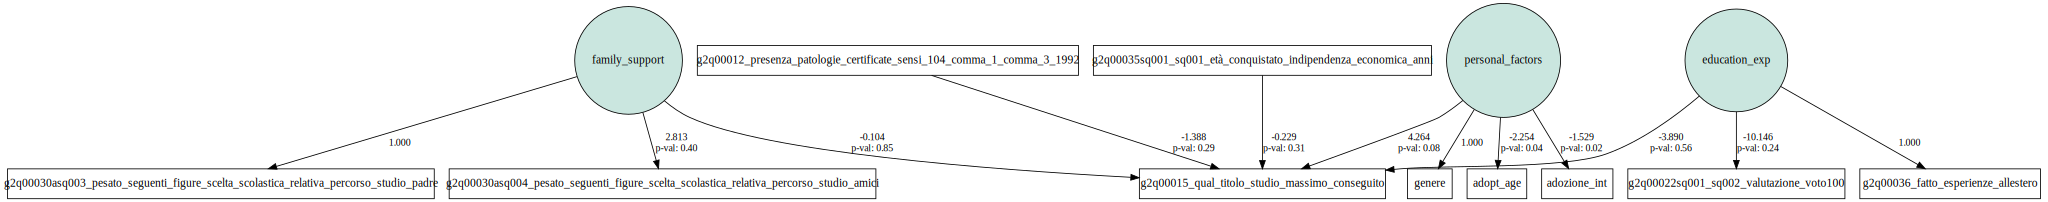

In [88]:
semplot(sem_model, filename='kids.png')